# My Plan

1- During data munging, I remove outlier (only TOTAL removed) and remove missing data (Removed data that did not have financial data). I removed all data that did not have 'salary' information. Rationale for doing so was that a classifer algorithm can identify missing data as a feature itself. As the number of POIs with missing data was minimal (i think 1), I thought it was ok to remove data without financial information. Also if you dont remove financial data, and impute missing values by 0, You will get an algorithm that has high precision, because of all the people in missing data, only 1 person is POI, rest are non-POIs. Do not impute median for missing data. This is not a good strategy for this data set. Reasons below, 

1.1- Many employees dont get additional financial incentives like bonus, restricted stock etc, so its not good to put median values for those people, its better to imput 0. Mainly because a lower level employee may actually be getting 0 additional incentives, and that data may not have been included in the data set.

1.2- About 60 data points have email features alone, and do not have financial data. I removed them completely. But putting median values for them may not be correct representation of data. For people with missing financial features, only 1 or 2 are POIs, so including or removing them, only increases or decreases precision and doesn't affect the overall approach in anyway. 

I only included data that had entries for salary. The ones that did not have salary information had only email features are removed. There was a lesson about choosing data from different sources, so I excluded ones with email completely, to avoid issues due to data from different sources.

2- Applied log(1+data) to financial information, to get more 'normal' distribution. I computed ratios for email features and added two new email radio features. 

3- Did PCA on financial features and selected 3 best. (PCA on training data only). (3- obtained using grid search CV)

3.1- Do not take PCAs on combined financial and email data. This is troublesome due to a lot of missing data, futher a hybrid email and financial data is tough to visualize for me, so I kept them separate. 

3.2- I chose 3 PCA components, because they explained 70% of variance in data for the features. 3-4 principal components may be sufficient to capture most of the variance in the data.

3.3- Do not select "total_payments" and "total_stock_incentives", because they are perfectly correlated with other features. 

4- The default 0.3 split from sklearn's cross validation function is used. In general smaller test_size implies overfitting. However, we are repeating this for all data points, so we are in a way using all the data. Further, in cases like this where the number of samples is low, using lower split actually avoids overfitting. Because in modeling, we are predicting only 1 data point, so the model has to be general enough to predict that 1 data sample that wasn't included in the original modeling. This is one of the reasons why when having test size of 0.3, we have high scores.

5- Applied gridsearchCV with custom scoring function and DecisionTree classifier. (I varied criterion and splitter). I do not use F1 score. Instead, I create my own scoring function. My scoring function was to maximize the minimum of precision and recall. This helped improve the performance significantly. F1 score is harmonic mean of precision and recall, so it tries to balance the two. It doesn't maximize either, but tries to keep both high and equal to one another. F1 = 2/(1/recall + 1/precision). I use make_scorer in sklearn to make custom scoring function.

6- For cross-validation I used the same tester function as that in tester.py. Sklearn's cross validation function uses the default 0.3 split. About using smaller test size, in general smaller test_size implies overfitting. However, we can repeat this for all data points, so we are in a way using all the data. Further, in cases like this where the number of samples is low, using lower split actually avoids overfitting. Because in modeling, we are predicting only 1 data point, so the model has to be general enough to predict that 1 data sample that wasn't included in the original modeling. This is one of the reasons why when we have test size of 0.3, you have high scores. "precision_recall" is a function I wrote to calculate precision and recall. It returns precision and recall from precitions and actual value. I thinkm, due to large difference in number of POIs and non-POIs,  18 pois in 150 people, when test_size is 0.1, we are predicting 2 or 1 POIs among 15, with test_sizxe is 0.3, we have 3 to 6 POIs in testing set. So even we only get 2 of them right, we have precision and recall above 0.3. So the scores appear artifitally high for a poorer model, like grade inflation. With 0.1, the model has to be generalize well to predict 1 data point, and any error is amplified. Regardless, it makes more sense to use 0.1 for test_size in gridsearchCV because thats what is used in tester.py. Also, the parameters of model are calculated based on CV object provided to gridsearchCV, so the parameters that give best score for 0.1 test size may be different from those for 0.3

Here is what I do:
6.1- We first divide the data set into a training and testing set of, say, 70%-30%.

6.2- On the 70% of the data that is put in the training set we then run the grid_search to train the model using the StratifiedShuffleSplit. Within the 'sss' the data is again randomly divided into 90-10 percent training-test sets for 1000 iterations, each iteration trains a model on 90% of the training set and tests on 10% of the original training set.

6.3- Then, the model with the parameters that have performed best on average, is used to generate predictions on the the 30% of the original data set that was set aside for testing. The predictions of that model are then compared to the actual values of the dependent variable to score the final model.


In [31]:
%matplotlib inline

import sys
import pickle
import pprint
import math
import matplotlib.pyplot
import os
import threading
import time
import datetime
sys.path.append("../ud120-projects/tools/")
sys.path.append("../ud120-projects/final_project/")

from sklearn.cross_validation import train_test_split
from sklearn.decomposition import RandomizedPCA
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import train_test_split


# Task 1: Select what features you'll use.

features_list is a list of strings, each of which is a feature name.
The first feature must be "poi".

In [32]:
features_list = ['poi','salary', 'bonus']
features_list

['poi', 'salary', 'bonus']

Load the dictionary containing the dataset

In [33]:
with open("../ud120-projects/final_project/final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

pp = pprint.PrettyPrinter(indent=4)
#pp.pprint(data_dict)

In [34]:
total_number = len(data_dict)
total_poi_number = sum( x['poi'] == True for x in data_dict.values() )
print "Total number of data points: ", total_number
print "Total number of POI: ", total_poi_number, " Percentage of POI: ", \
       round(total_poi_number / (1.0 * total_number), 4) * 100, "%"
print "Total number of non-POI: ", total_number - total_poi_number, \
       " Percentage of non-POI: ", (1 - round(total_poi_number / (1.0 * total_number), 4))* 100, "%"

Total number of data points:  146
Total number of POI:  18  Percentage of POI:  12.33 %
Total number of non-POI:  128  Percentage of non-POI:  87.67 %


In [35]:
my_chosen_feature_list = ['total_payments', 'total_stock_value']
for i in my_chosen_feature_list:
    print "Total number of missing values for feature '", i, "' is: ", \
    sum( x[i] == "NaN" for x in data_dict.values() )
    

Total number of missing values for feature ' total_payments ' is:  21
Total number of missing values for feature ' total_stock_value ' is:  20


# Task 2: Remove outliers

## Step #1

Here I will at first remove all data that did not have 'salary' information. In other words, I will remove the person whose 'salary' is 'NaN'.

In [36]:
len(data_dict)

146

In [37]:
data_dict_no_NaN = {name:data_dict[name] for name in data_dict if data_dict[name]["salary"] != "NaN"}
len(data_dict_no_NaN)

95

In [38]:
#data_dict_no_NaN

## Step #2

A new function draw_scatterplot() is created here to draw the scatter plot for the data. This visualizes where the outliers are.

In [39]:
# Red dots in the scatter plot are POI's 
# Blue dots are not POI's
def draw_scatterplot(featurelist, datadict):
    data = featureFormat(datadict, featurelist)
    for point in data:
        if point[0] != 0:
            color = 'red'
        else:
            color = 'blue'
        matplotlib.pyplot.scatter( point[1], point[2], color = color)
    matplotlib.pyplot.xlabel( featurelist[1] )
    matplotlib.pyplot.ylabel( featurelist[2] )
    matplotlib.pyplot.show()

Draw the scatter plot for all data. Let us see the outliers. I am using 'salary' and 'bonus' as the features to study. As I mentioned in the code above, the red dots in the scatter plot are POI's, and the blue dots in the scatter plot are non-POI's

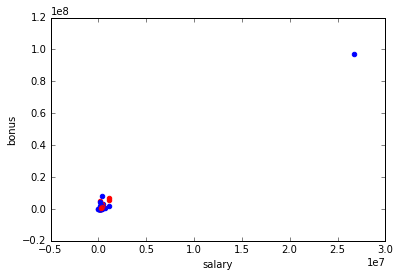

In [40]:
features_list = ['poi','salary', 'bonus']
draw_scatterplot(features_list, data_dict_no_NaN)

In the scatter plot above, a blue dot is found with much bigger bonus and salary. Now I need to find out who this is.

Define the function Remove_Max_Outlier() to remove the outliers from the dataset.

In [41]:
def Remove_Max_Outlier(datadict, feature):
    v=list(k[feature] for k in datadict.values())
    k=list(datadict.keys())
    name = k[v.index(max(v))]
    print name
    print datadict[name][feature]

    del datadict[name]
    return datadict

Now run this function to remove the outlier. It also print out some information about this outlier.

In [42]:
data_dict_no_Outlier = Remove_Max_Outlier(data_dict_no_NaN, "total_payments")
#data_dict_no_Outlier

TOTAL
309886585


Draw a scatter plot to see which outliers are removed. As I mentioned before, the red dots are POI's. the blue dots are non-POI's.

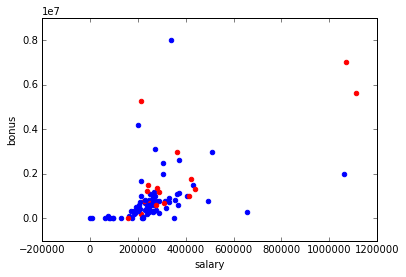

In [43]:
draw_scatterplot(features_list, data_dict_no_Outlier)

# Task 3: Change the value of data to get more normal distribution

## Step #1, Apply log (1+data) to financial features in the dataset

Applied log(1+data) to financial information, and to email information to get more 'normal' distribution. I computed ratios and log-transformed them for email features, and took log of financial data. 

Now I need to set all data to be zero, if it is NaN. To do this, I define a function NaN_to_Zero().

In [44]:
def NaN_to_Zero(featurelist, datadict):
    for key, value in datadict.items():
        for i in featurelist:
            if type(value[i]) is float and math.isnan(value[i]) or type(value[i]) is str and value[i] == "NaN" :
                datadict[key][i] = 0
    return datadict

Now I call this function to change any "NaN" value in the data_dict_no_Outlier to zero for the listed features. Feature 'deferred_income' and 'restricted_stock_deferred' are not taken into consideration because it has negative values, and we not able to apply log calculation on it.

In [45]:
features_list = ['bonus', 'deferral_payments', 'director_fees', 'exercised_stock_options', \
                 'expenses', 'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', \
                 'salary', 'total_payments', 'total_stock_value']
data_dict_no_NaN2 = NaN_to_Zero(features_list, data_dict_no_Outlier)
#data_dict_no_NaN2

In [46]:
for name in data_dict_no_NaN2:
    data_point = data_dict_no_NaN2[name]
    for i in features_list:
        data_point[i] = math.log(float(data_point[i]) + 1.0)
#data_dict_no_NaN2

## Step #2, Calculate ratios to create the new email features

Here I will create two new email features "fraction_from_poi" and "fraction_to_poi". As you may know, feature "fraction_from_poi" is the result of feature "from_this_person_to_poi" divided by feature "from_messages". And feature "fraction_to_poi" is the result of feature "from_poi_to_this_person" divided by feature "to_messages".

Here I define the function computeFraction() to do the calculation:

In [47]:
def computeFraction( poi_messages, all_messages ):
    """ given a number messages to/from POI (numerator) 
        and number of all messages to/from a person (denominator),
        return the fraction of messages to/from that person
        that are from/to a POI
   """
    ### this function returns either
    ###     the fraction of all messages to this person that come from POIs
    ###     or
    ###     the fraction of all messages from this person that are sent to POIs
    ### the same code can be used to compute either quantity

    ### beware of "NaN" when there is no known email address (and so
    ### no filled email features), and integer division!
    ### in case of poi_messages or all_messages having "NaN" value, return 0.
    fraction = 0.
    if poi_messages == "NaN" or all_messages == "NaN" or all_messages == 0:
        return fraction
    fraction = 1.0 * poi_messages / all_messages
    return fraction

Add the two new features "fraction_from_poi" and "fraction_to_poi".

In [48]:
for name in data_dict_no_NaN2:

    data_point = data_dict_no_NaN2[name]

    from_poi_to_this_person = data_point["from_poi_to_this_person"]
    to_messages = data_point["to_messages"]
    fraction_from_poi = computeFraction( from_poi_to_this_person, to_messages )
    data_point["fraction_from_poi"] = fraction_from_poi

    from_this_person_to_poi = data_point["from_this_person_to_poi"]
    from_messages = data_point["from_messages"]
    fraction_to_poi = computeFraction( from_this_person_to_poi, from_messages )
    data_point["fraction_to_poi"] = fraction_to_poi
    

In [49]:
#data_dict_no_NaN2

Here let us look at the scatter plot from the two new features.

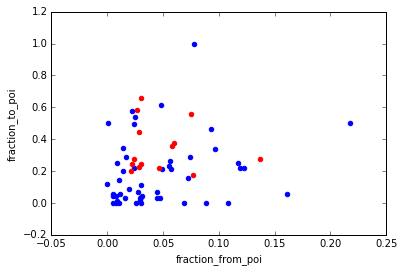

In [50]:
features_list = ['poi', 'fraction_from_poi', 'fraction_to_poi']

draw_scatterplot(features_list, data_dict_no_NaN2)

From this scatterplot, we can see that POI stays at an area where fracton_from_poi is in 0 to 0.15, and fraction_to_poi is in 0.1 to 0.7.

Store to my_dataset for easy export below.

In [51]:
my_dataset = data_dict_no_NaN2

# Task 4: Select the Features

In the study, I will only select the financial features. And among the financial features some features can not be used. These unused features are:<br/>
1, "Total Payments" and "Total Stock Values". The values of both features are calculated from other financial features.<br/>
2, "Deferred Income" and "Restricted Stock Deferred". The values of both features are negative. It requires some special handling on these negative values. For now I choose to ignore them.<br/>

So the features list is:

In [52]:
features_list = ['poi', 'bonus', 'deferral_payments', 'director_fees', 'exercised_stock_options', \
                 'expenses', 'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', \
                 'salary']

Generate the dataset for the selected features above.

In [53]:
data = featureFormat(my_dataset, features_list, remove_all_zeroes=False, sort_keys = True)
data

array([[  0.        ,  15.24462516,  14.86972433, ...,   5.03043792,
         11.74425938,  12.21580513],
       [  0.        ,   0.        ,   0.        , ...,  13.66993435,
         14.37943306,   6.16961073],
       [  0.        ,  13.99783295,  14.07459175, ...,  14.79395096,
         15.18738013,  12.49538963],
       ..., 
       [  0.        ,  14.91412318,   0.        , ...,  12.61495524,
         14.84376404,  13.14288143],
       [  0.        ,  13.01700508,   0.        , ...,  13.8975181 ,
         16.44358458,  12.66837167],
       [  1.        ,   0.        ,   0.        , ...,  11.90463642,
         15.0898133 ,  11.97290401]])

To select the features, there are two ways:<br/>
1, Select the features manually.  I write the code to loop through the features and find which onces are important.<br\>
2, Select the features by calling RandomizedPCA().

I tried both. And I choose finaly to select the features manually. I will show the reason later.

When doing PCA, I find that I need to select 3 components to preserve most of the variance.

In [54]:
pca = RandomizedPCA(n_components=3, whiten=True)
pca.fit(data)

print "pca.explained_variance_ratio_: "
print pca.explained_variance_ratio_
print "first_pc = ", pca.components_[0], "Length = ", len(pca.components_[0])
print "second_pc = ", pca.components_[1], "Length = ", len(pca.components_[1])
print "third_pc = ", pca.components_[2], "Length = ", len(pca.components_[2])

pca.explained_variance_ratio_: 
[ 0.260902    0.22110866  0.17130492]
first_pc =  [  6.70524909e-06  -1.34298249e-02  -5.56515854e-02   1.74564542e-18
  -9.85834553e-02   1.26412139e-02  -1.13413421e-02  -8.20958521e-02
  -2.02554869e-02  -1.48927064e-02  -3.09277097e-03] Length =  11
second_pc =  [ -1.80797177e-03  -5.37291522e-02   9.32031081e-02   4.33424848e-18
   3.95376707e-02  -1.40579780e-02   5.47763421e-03  -8.75289072e-02
  -3.59410639e-02  -4.50521813e-02  -5.89138272e-03] Length =  11
third_pc =  [ -5.79782558e-04  -1.33458753e-02   7.75166421e-02   1.96966221e-17
  -1.08554428e-01  -6.16175591e-02   9.43177124e-04   8.02385767e-02
   2.35635511e-03  -5.70576074e-02  -2.54897298e-03] Length =  11


# Task 5: Select the algorithm

I have tried four algorithms: GaussionNB, DecisionTree, RandomForest, and SVC.

I will show it later.

# Task 6: Preparation: Define the custom Scoring function

I am going to apply gridsearchCV() with a custom scoring function I define and alogrithm classifier. My scoring function was to maximize the minimum of precision and recall, instead of F1-score. This helps improve the performance significantly. F1 score is harmonic mean of precision and recall, so it tries to balance the two. It doesn't maximize either, but tries to keep both high and equal to one another. F1 = 2/(1/recall + 1/precision). So I do not choose F1-score. Instead, I choose to use the minimum of the precision and recall. I use make_scorer in sklearn to make custom scoring function.

In [55]:
def precision_recall(labels, predictions):
    ind_true_pos = [i for i in range(0,len(labels)) if (predictions[i]==1) & (labels[i]==1)]
    ind_false_pos = [i for i in range(0,len(labels)) if ((predictions[i]==1) & (labels[i]==0))]
    ind_false_neg = [i for i in range(0,len(labels)) if ((predictions[i]==0) & (labels[i]==1))]
    ind_true_neg = [i for i in range(0,len(labels)) if ((predictions[i]==0) & (labels[i]==0))]
    precision = 0
    recall = 0
    
    ind_labels = [i for i in range(0,len(labels)) if labels[i]==1]
    
    if len(ind_labels) !=0:
        if float( len(ind_true_pos) + len(ind_false_pos))!=0:
            precision = float(len(ind_true_pos))/float( len(ind_true_pos) + len(ind_false_pos))
        if float( len(ind_true_pos) + len(ind_false_neg))!=0:
            recall = float(len(ind_true_pos))/float( len(ind_true_pos) + len(ind_false_neg))
        return precision, recall
    else:
        return -1,-1

def custom_scorer(labels, predictions):
    precision, recall = precision_recall(labels, predictions)
    min_score = min(precision, recall)
    return min_score
score  = make_scorer(custom_scorer, greater_is_better=True)

# Task 7: Preparation: Cross-validation function

For cross-validation I used the same tester functions train_test_split() and StratifiedShuffleSplit() as that in tester.py.<br\>

Here is what I am going to do:<br\>1, we first divide the data set into a training and testing set of, say, 70%-30%.
On the 70% of the data that is put in the training set we then run the grid_search to train the model using the StratifiedShuffleSplit.<br\>2, Within the 'sss', the data is again randomly divided into 90%-10% training-test sets for 1000 iterations. Each iteration trains a model on 90% of the training set and tests on 10% of the original training set.<br\>
3, Then, the model with the parameters that have performed best on average, is then used to generate predictions on the the 30% of the original data set that was set aside for testing.<br\>4,The predictions of that model are then compared to the actual values of the dependent variable to score the final model.<br\>

sklearn's cross validation function uses the default 0.3 split. But using smaller test_size, in general, implies overfitting. However, you can repeat this for all data points, so you are in a way using all the data. Further, in cases like this where the number of samples is low, using lower split actually avoids overfitting. Because in modeling, you are predicting only 1 data point, so the model has to be general enough to predict that 1 data sample that wasn't included in the original modeling. This is one of the reasons why when you have test size of 0.3, you have high scores.<br\> This is my reasoning for 0.1 vs 0.3.<br\>
In other words, this is due to large difference in number of POIs and non-POIs. 18 POIs in 150 people. When test_size is 0.1, you are predicting 2 or 1 POIs among 15, where as when it is done with 0.3, you have 3 to 6 POIs in testing set. So even you get 2 of them right, you have precision and recall above 0.3. So the scores appear artifitally high for a poorer model, like grade inflation. With 0.1, the model has to be generalize well to predict 1 data point, and any error is amplified. Regardless, it makes more sense to use 0.1 for test_size in gridsearchCV because that is what is used in tester.py. Also, the parameters of model are calculated based on CV object provided to gridsearchCV, so the parameters that give best score for 0.1 test size may be different from those for 0.3.<br\>

You will see how I call train_test_split() and StratifiedShuffleSplit(), as well as GridSearchCV() later in my code.

Here I have a output function get_outcomes(). It prints out all important informations from grid_search.

In [56]:
def get_outcomes(gridCV):
    '''Gets the print out of all the outcomes from the grid_search. It prints out the 
    best parameters found by the model and the outcomes of the test of the model on 
    the test set.'''
    print "Best parameters from the grid search: ", gridCV.best_params_
    clf_gridCV = gridCV.best_estimator_
    print "\nBest Estimator Accuracy:", clf_gridCV.score(features_test, labels_test)
    clf_gridCV_pred = clf_gridCV.predict(features_test)
    print "\n\nRecall Score:", recall_score(labels_test, clf_gridCV_pred)
    print "\n\nPrecision Score:", precision_score(labels_test, clf_gridCV_pred)

# Task 8: Code

I have tried several different algorithms with one of two ways to select features. I list them here:<br\>
1, PCA + SVC + Pipeline + GridSearchCV<br\>
2, PCA + DecisionTree + Pipeline + GridSearchCV<br\>
3, PCA + RandomForest + Pipeline + GridSearchCV<br\>
4, manually selecting features + DecisionTree + GridSearchCV<br\>
5, manually selecting features + RandomForest + GridSearchCV

## Task 8.1: PCA + SVC + Pipeline + GridSearchCV

The calculation of this solution takes a very long time. So I have to run one EC2 instance "r3.8xlarge" in Amazon Web Service (AWS). This interface have 32 virtual CPUs and 244G memory. It takes about 36 hours to finish the calculation. To fully use the 32 virtual CPUS, I need to change the code to use threads to do the calculation: Run one thread for one set of parameters.

In [58]:

labels, features = targetFeatureSplit(data)

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=42)


def get_outcomes2(gridCV, file_handle):

    '''Gets the print out of all the outcomes from the grid_search. It prints out the 
    best parameters found by the model and the outcomes of the test of the model on 
    the test set.'''
    
    file_handle.write("\n\nBest parameters from the grid search: " + str(gridCV.best_params_))
    clf_gridCV = gridCV.best_estimator_
    file_handle.write("\n\nBest Estimator Accuracy:" + str(clf_gridCV.score(features_test, labels_test)))
    clf_gridCV_pred = clf_gridCV.predict(features_test)
    file_handle.write("\n\nRecall Score:" + str(recall_score(labels_test, clf_gridCV_pred)))
    file_handle.write("\n\nPrecision Score:" + str(precision_score(labels_test, clf_gridCV_pred)))
            
sss = StratifiedShuffleSplit(labels_train, n_iter=1000, test_size=0.1, random_state=42)                       

Pipeline = Pipeline([
        ('pca', RandomizedPCA()),
        ('clf', SVC(random_state = 42))
    ])

def worker(xi, di, si, mi):
    folder = "./pipeline_svc_thread_result/test_result_xi_" + str(xi[0]) + "_di_" + str(di[0]) + "_si_" + str(si[0]) + "_mi_" + str(mi[0]) + "/"

    dir = os.path.dirname(folder)
    if not os.path.exists(dir):
        os.makedirs(folder)

    f = open(folder + "result.txt", "a+")

    param_grid = {'pca__n_components': xi,
              'clf__C': ci,
              'clf__gamma': gi,
              'clf__kernel': di}

    clf = GridSearchCV(estimator = Pipeline, 
                             param_grid = param_grid,
                             scoring = score,
                             cv = sss)

    f.write(str(clf))

    f.write("\n\nTraining starts at: " + datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

    clf.fit(features_train, labels_train)
    f.write("\n\nTraining ends at: " + datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

# print all the outcomes of interest
    get_outcomes2(clf, f)
    my_features_list = features_list

    dump_classifier_and_data(folder, clf, my_dataset, features_list)

    f.close()

x = [[3]]
d = [['rbf'],['linear'], ['poly']]
c = [[10], [100], [500]]
g = [[0.01], [0.1], [1]]

for xi in x:
    for di in d:
        for ci in c:
            for gi in g:
                t = threading.Thread(target=worker, args=(xi, di, ci, gi))
    t.start()

However its result is not good. The value of recall never goes beyond 0.3 for different paramter settings. Its maximum value is 0.2857. The best result is:

Training starts at: 2016-08-31 11:10:21

Training ends at: 2016-09-01 17:22:27

Best parameters from the grid search: {'clf__gamma': 1, 'pca__n_components': 3, 'clf__C': 10, 'clf__kernel': 'poly'}

Best Estimator Accuracy:0.793103448276

Recall Score:0.285714285714

Precision Score:0.66666666666

## Task 8.2: PCA + RandomForest + Pipeline + GridSearchCV

In [59]:
labels, features = targetFeatureSplit(data)

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=42)
            
sss = StratifiedShuffleSplit(labels_train, n_iter=1000, test_size=0.1, random_state=42)                       

Pipeline = Pipeline([
        ('pca', RandomizedPCA()),
        ('clf', RandomForestClassifier(random_state = 42))
    ])


x = [3]
#d = ['rbf', 'linear', 'poly', 'sigmoid']

d = ['entropy', 'gini']
n = [450, 500, 650]
#n = [10]
s = [1]
#s = [10]
m = [7, 8, 9]
#m = [2]

param_grid = {'pca__n_components': x,
              'clf__n_estimators': n,
              'clf__min_samples_split': s,
              'clf__max_depth': m,
              'clf__criterion': d}


clf = GridSearchCV(estimator = Pipeline, 
                             param_grid = param_grid,
                             scoring = score,
                             cv = sss)

print clf

print len(features_train)
print len(labels_train)

import time
t0 = time.time()
print "Training starts at: ", time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(t0))
clf.fit(features_train, labels_train)
t1 = time.time()
print "Training ends at: ", time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(t1))
print "Fitting is done."

# print all the outcomes of interest
get_outcomes(clf)

my_features_list = features_list

dump_classifier_and_data(clf, my_dataset, features_list)


TypeError: 'Pipeline' object is not callable

Its result is not good, either. The value of recall never goes beyond 0.3 for different paramter settings. Its maximum value is 0.1429. Below is the best result:


Training starts at:  2016-08-14 09:24:21
Training ends at:  2016-08-14 15:19:49
Fitting is done.
Best parameters from the grid search:  {'pca__n_components': 3, 'clf__criterion': 'gini', 'clf__max_depth': 8, 'clf__n_estimators': 500, 'clf__min_samples_split': 1}

Best Estimator Accuracy: 0.793103448276


Recall Score: 0.142857142857


Precision Score: 1.0


## Task 8.3: PCA + DecisionTree + Pipeline + GridSearchCV

In [31]:

#print data
labels, features = targetFeatureSplit(data)

#print labels
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=42)

           
sss = StratifiedShuffleSplit(labels_train, n_iter=1000, test_size=0.1, random_state=42)                       

Pipeline = Pipeline([
        ('pca', RandomizedPCA()),
        ('clf', DecisionTreeClassifier(random_state = 42))
    ])


x = [3]
#d = ['rbf', 'linear', 'poly', 'sigmoid']

d = ['entropy', 'gini']
#n = [10]
s = [1]
#s = [10]
m = [7, 8, 9]
#m = [2]

param_grid = {'pca__n_components': x,
              'clf__min_samples_split': s,
              'clf__max_depth': m,
              'clf__criterion': d}


clf = GridSearchCV(estimator = Pipeline, 
                             param_grid = param_grid,
                             scoring = score,
                             cv = sss)

import time
t0 = time.time()
print "Training starts at: ", time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(t0))
clf.fit(features_train, labels_train)
t1 = time.time()
print "Training ends at: ", time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(t1))
print "Training time is ", time.strftime('%M:%S', time.localtime(t1-t0))
print "Fitting is done."

# print all the outcomes of interest
get_outcomes(clf)

my_features_list = features_list

dump_classifier_and_data(clf, my_dataset, features_list)


TypeError: 'Pipeline' object is not callable

Its result is not good, either. The value of recall never goes beyond 0.3 for different paramter settings. Its maximum value is 0.1429. Below is the best result:


Training starts at:  2016-08-14 18:59:47
Training ends at:  2016-08-14 19:00:23
Training time is  00:35
Fitting is done.
Best parameters from the grid search:  {'clf__criterion': 'gini', 'clf__max_depth': 8, 'pca__n_components': 3, 'clf__min_samples_split': 1}

Best Estimator Accuracy: 0.724137931034


Recall Score: 0.142857142857


Precision Score: 0.333333333333

## Task 8.4: Manually Select Features + RandomForest + GridSearchCV

Since using Pipeline + PCA, I am not able to get the good result. Then I decide to manually select features. So in the following code, two different features are selected from the feature lists each time. I am trying to find out which two features have the best and qualified result. The reason I choose two features each time is for reducing the calculation time.

In [ ]:
total_features_list = ['bonus', 'deferral_payments', 'director_fees', 'exercised_stock_options', \
                 'expenses', 'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', \
                 'salary']

features_list = ['poi']

f = open("poi_id_randomforest_loopfeatures_result.txt", 'w')

i = total_features_list[0]
while (len(total_features_list) > 1):
    features_list = ['poi']
    features_list.append(i)
    total_features_list.remove(i)
    i = total_features_list[0]
    for j in total_features_list:
        features_list.append(j)
        print features_list
        f.write(str(features_list) + "\n")
        
        data = featureFormat(my_dataset, features_list, remove_all_zeroes=False, sort_keys = True)

#print data
        labels, features = targetFeatureSplit(data)

#print labels
        features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=42)


# RandomForest
        ran = RandomForestClassifier()
        parameters = {"n_estimators" : [1, 2, 3, 4],
              "min_samples_split" : [5, 10, 15],
              "max_depth": [2, 3, 4, 5],
              "criterion" : ['entropy', 'gini']}
            
        sss = StratifiedShuffleSplit(labels_train, n_iter=1000, test_size=0.1, random_state=42)                       
        clf = GridSearchCV(ran,
                   param_grid = parameters,
                   scoring = score,
                   cv = sss) 

        t0 = time.time()
        t0_value = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(t0))
        print "Training starts at: ", t0_value
        f.write("Training starts at: " + str(t0_value) + "\n")
        clf.fit(features_train, labels_train)
        t1 = time.time()
        t1_value = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(t1))
        f.write("Training ends at: " + str(t1_value) + "\n")
        print "Training ends at: ", t1_value

# print all the outcomes of interest
        get_outcomes2(clf, f)

        features_list.remove(j)

f.close()


However the result is not good. The best result is:

['poi', 'loan_advances', 'restricted_stock']
Training starts at: 2016-10-04 05:10:20
Training ends at: 2016-10-04 05:21:11
Best parameters from the grid search: {'min_samples_split': 5, 'n_estimators': 1, 'criterion': 'entropy', 'max_depth': 5}

Best Estimator Accuracy: 0.689655172414


Recall Score: 0.285714285714


Recall Score: 0.285714285714


## Task 8.5: Manually Select Features + DecisionTree + GridSearchCV

In this solution, two different features are selected from the feature lists each time. And RandomForestClassifier is run. GridSearchCV() is used to get the best result.

In [ ]:
total_features_list = ['bonus', 'deferral_payments', 'director_fees', 'exercised_stock_options', \
                 'expenses', 'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', \
                 'salary']

features_list = ['poi']

f = open("poi_id_dt_loopfeatures_result.txt", 'w')

i = total_features_list[0]
while (len(total_features_list) > 1):
    features_list = ['poi']
    features_list.append(i)
    total_features_list.remove(i)
    i = total_features_list[0]
    for j in total_features_list:
        features_list.append(j)
        print features_list
        f.write(str(features_list) + "\n")
                 
        data = featureFormat(my_dataset, features_list, remove_all_zeroes=False, sort_keys = True)

#print data
        labels, features = targetFeatureSplit(data)

#print labels
        features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=42)


# Decision Tree
        dtc = DecisionTreeClassifier(random_state = 42)
        parameters = {"criterion" : ["gini", "entropy"],
                      "splitter" :   ["best", "random"]}  
            
        sss = StratifiedShuffleSplit(labels_train, n_iter=1000, test_size=0.1, random_state=42)                       
        clf = GridSearchCV(dtc,
                   param_grid = parameters,
                   scoring = score,
                   cv = sss) 


        t0 = time.time()
        t0_value = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(t0))
        print "Training starts at: ", t0_value
        f.write("Training starts at: " + str(t0_value) + "\n")
        clf.fit(features_train, labels_train)
        t1 = time.time()
        t1_value = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(t1))
        f.write("Training ends at: " + str(t1_value) + "\n")
        print "Training ends at: ", t1_value

# print all the outcomes of interest
        get_outcomes2(clf, f)

        features_list.remove(j)

f.close()


With this solution, I get some good results:
    
['poi', 'exercised_stock_options', 'salary']
Training starts at: 2016-10-03 22:10:59
Training ends at: 2016-10-03 22:11:10
Best parameters from the grid search: {'splitter': 'best', 'criterion': 'entropy'}

Best Estimator Accuracy: 0.758620689655


Recall Score: 0.428571428571


Recall Score: 0.42857142857    
    
    
    
['poi', 'expenses', 'salary']
Training starts at: 2016-10-03 22:11:49
Training ends at: 2016-10-03 22:11:59
Best parameters from the grid search: {'splitter': 'random', 'criterion': 'gini'}

Best Estimator Accuracy: 0.724137931034


Recall Score: 0.428571428571


Recall Score: 0.42857142857    
    